In [1]:
import tensorflow as tf
import gc
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Activation, BatchNormalization, Dropout, LSTM, ConvLSTM2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, LSTM, ConvLSTM2D, Lambda, Reshape, BatchNormalization, Bidirectional
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, LearningRateScheduler, CSVLogger
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.layers import Lambda, Reshape, DepthwiseConv2D, ZeroPadding2D, Add, MaxPooling2D,Activation, Flatten, Conv2D, Dense, Input, Dropout, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers.experimental import preprocessing
from keras.applications import imagenet_utils
from tensorflow.keras import layers
!pip install tensorflow-addons
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import random
import keras
import shutil
import pathlib
import itertools
import cv2
import os
import matplotlib.image as mpimg
import seaborn as sns

2024-05-13 17:57:39.256055: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 17:57:39.256155: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 17:57:39.521175: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 which is incompatible.


/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training/'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing/'

In [3]:
for dirpath, dirnames, filenames in os.walk(train_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 4 directories and 0 images in '/kaggle/input/brain-tumor-mri-dataset/Training/'.
There are 0 directories and 1457 images in '/kaggle/input/brain-tumor-mri-dataset/Training/pituitary'.
There are 0 directories and 1595 images in '/kaggle/input/brain-tumor-mri-dataset/Training/notumor'.
There are 0 directories and 1339 images in '/kaggle/input/brain-tumor-mri-dataset/Training/meningioma'.
There are 0 directories and 1321 images in '/kaggle/input/brain-tumor-mri-dataset/Training/glioma'.


In [4]:
for dirpath, dirnames, filenames in os.walk(test_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 4 directories and 0 images in '/kaggle/input/brain-tumor-mri-dataset/Testing/'.
There are 0 directories and 300 images in '/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary'.
There are 0 directories and 405 images in '/kaggle/input/brain-tumor-mri-dataset/Testing/notumor'.
There are 0 directories and 306 images in '/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma'.
There are 0 directories and 300 images in '/kaggle/input/brain-tumor-mri-dataset/Testing/glioma'.


In [5]:
def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");
  print(f"Image shape: {img.shape}")
  return img

Image shape: (512, 512, 3)


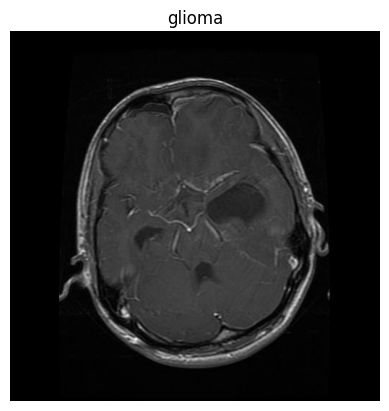

In [6]:
img = view_random_image(target_dir=test_dir,
                        target_class="glioma")

In [7]:
EPOCHS = 50
from math import floor
N_FOLDS = 5
INIT_LR = 1e-3
T_BS = 16
V_BS = 16
decay_rate = 0.95
decay_step = 1
IMAGE_SIZE = [224,224]

In [8]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

def augment_image(image, label):
    # Apply augmentation transformations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)

    # Apply the width and height shifts
    width_shift = tf.random.uniform([], -0.2, 0.2) * tf.cast(tf.shape(image)[1], tf.float32)
    height_shift = tf.random.uniform([], -0.2, 0.2) * tf.cast(tf.shape(image)[0], tf.float32)
    image = tfa.image.translate(image, [width_shift, height_shift])

    return image, label

In [9]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 batch_size=32,
                                                                 image_size=IMAGE_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SIZE,
                                                                shuffle=False)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


# Applying Augmentation using map function

In [10]:
train_dataset_augmented = train_data.map(augment_image)

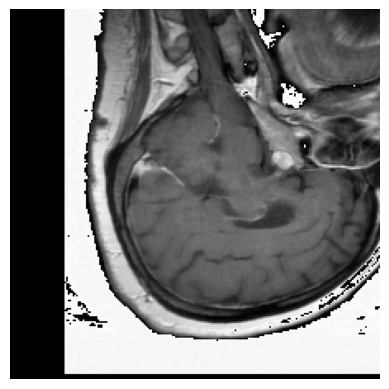

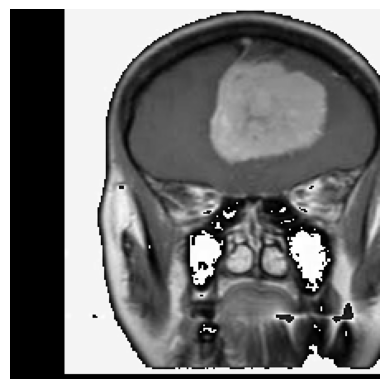

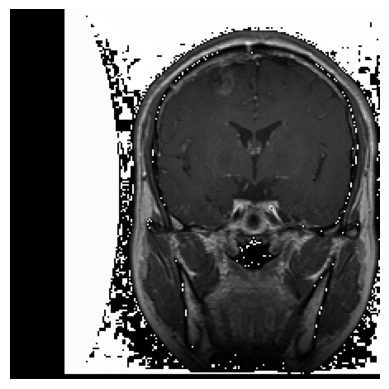

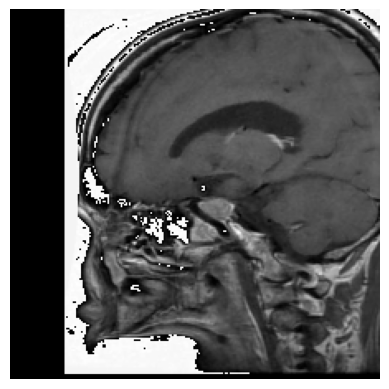

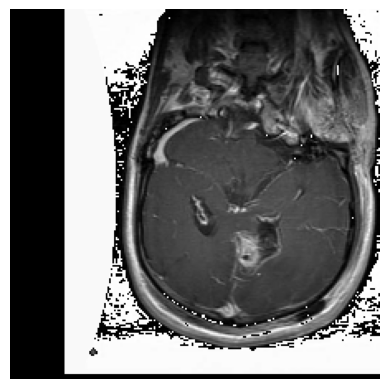

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_image(image, label):
    plt.imshow(image)
    plt.axis("off")
    plt.show()

count = 0
for batch in train_dataset_augmented:
    images, labels = batch
    for i in range(len(images)):
        display_image(images[i].numpy().astype("uint8"), labels[i].numpy())
        count += 1
        if count >= 5:
            break
    if count >= 5:
        break

In [12]:
from keras.models import Model
from keras.layers import Input, LSTM, Reshape, BatchNormalization, Flatten, Dense
from keras.applications.vgg19 import VGG19
from keras.optimizers import Adam
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def Combined_model():
    # Input layer
    input_layer = Input(shape=(224, 224, 3))

    # Base VGG19 model as a feature extractor
    baseModel = VGG19(weights='imagenet', include_top=False, input_tensor=input_layer)

    # Freeze the layers of the VGG19 model
    for layer in baseModel.layers:
        layer.trainable = False

    x = baseModel.output

    # LSTM layer
    x = Reshape((49, 512))(x)
    x = LSTM(512, activation="relu", return_sequences=True, trainable=False)(x)
    x = BatchNormalization()(x)

    # Flatten output from LSTM
    x = Flatten()(x)

    # Convert LSTM output to numpy array
    lstm_features = x

    # SVM Classifier
    svm_model = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=64)),  # You can adjust the number of PCA components
        ("svm", SVC(kernel="linear", C=1.0, probability=True))
    ])

    # Output layer
    output = Dense(4, activation='softmax')(lstm_features)

    model = Model(inputs=input_layer, outputs=output)
    opt = Adam(lr=1e-3)  # Fixed learning rate value, assuming you intended 1e-3
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
    
    return model

# Create the model
model = Combined_model()

# Print the model summary
model.summary()


80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [13]:
checkpoint = [ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy',mode='max',verbose=1,save_best_only=True,save_weights_only=True),
             LearningRateScheduler(lambda epoch : INIT_LR * pow(decay_rate, floor(epoch / decay_step)))]
earlystop = EarlyStopping(monitor='accuracy', min_delta=0, patience=15, verbose=1, mode='max')

In [14]:
history = model.fit(train_dataset_augmented,
                    epochs=50,
                    steps_per_epoch=len(train_dataset_augmented),
                    validation_data = test_data,
                    callbacks=[checkpoint])

Epoch 1/50


I0000 00:00:1715623137.284469      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 [==============================] - ETA: 0s - loss: 0.8856 - accuracy: 0.7920
Epoch 1: val_accuracy improved from -inf to 0.81236, saving model to best_model.h5
179/179 [==============================] - 65s 287ms/step - loss: 0.8856 - accuracy: 0.7920 - val_loss: 1.0160 - val_accuracy: 0.8124 - lr: 0.0010
Epoch 2/50
179/179 [==============================] - ETA: 0s - loss: 0.6652 - accuracy: 0.8563
Epoch 2: val_accuracy improved from 0.81236 to 0.85584, saving model to best_model.h5
179/179 [==============================] - 38s 210ms/step - loss: 0.6652 - accuracy: 0.8563 - val_loss: 0.7154 - val_accuracy: 0.8558 - lr: 9.5000e-04
Epoch 3/50
179/179 [==============================] - ETA: 0s - loss: 0.6230 - accuracy: 0.8701
Epoch 3: val_accuracy improved from 0.85584 to 0.87109, saving model to best_model.h5
179/179 [==============================] - 39s 217ms/step - loss: 0.6230 - accuracy: 0.8701 - val_loss: 0.6850 - val_accuracy: 0.8711 - lr: 9.0250e-04
Epoch 4/50
179/179 

In [15]:
model.load_weights('/kaggle/working/best_model.h5')
_, accuracy = model.evaluate(test_data)
print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

41/41 [==============================] - 7s 159ms/step - loss: 0.1500 - accuracy: 0.9619
Validation accuracy: 96.19%


In [16]:
pred_probs = model.predict(test_data, verbose=1)

41/41 [==============================] - 7s 156ms/step


In [17]:
pred_classes = pred_probs.argmax(axis=1)

y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

In [18]:
target_names = ['Glioma', 'Meningioma', 'No Tumor','Pituitary']
print(classification_report(y_labels,
                            pred_classes,
                            target_names=target_names, digits=4))

              precision    recall  f1-score   support

      Glioma     0.9648    0.9133    0.9384       300
  Meningioma     0.9175    0.9444    0.9308       306
    No Tumor     0.9950    0.9901    0.9926       405
   Pituitary     0.9612    0.9900    0.9754       300

    accuracy                         0.9619      1311
   macro avg     0.9596    0.9595    0.9593      1311
weighted avg     0.9623    0.9619    0.9618      1311



In [19]:
cm = confusion_matrix(y_labels,pred_classes)

TP = cm[0, 0]
TN = cm[1:, 1:].sum()
FP = cm[0, 1:].sum()
FN = cm[1:, 0].sum()

Population = TN+FN+TP+FP
spesificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)

print("True Positives:", TP)
print("False Positives:", FP)
print("True Negatives:", TN)
print("False Negatives:", FN)
print("Specificity:", spesificity)
print("Sensitivity:", sensitivity)

True Positives: 274
False Positives: 26
True Negatives: 1001
False Negatives: 10
Specificity: 0.9746835443037974
Sensitivity: 0.9647887323943662


In [20]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(20, 20), text_size=15, norm=False, savefig=False):

  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0]

  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  ax.grid(False)

  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes),
         xticklabels=labels,
         yticklabels=labels)

  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  threshold = (cm.max() + cm.min()) / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

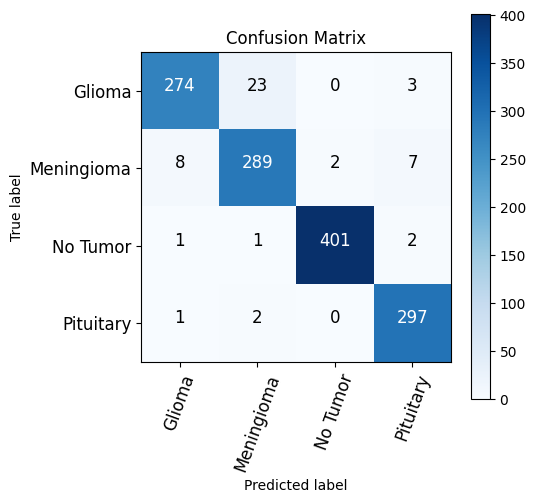

In [21]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=target_names,
                      figsize=(5, 5),
                      text_size=12,
                      norm=False,
                      savefig=True)

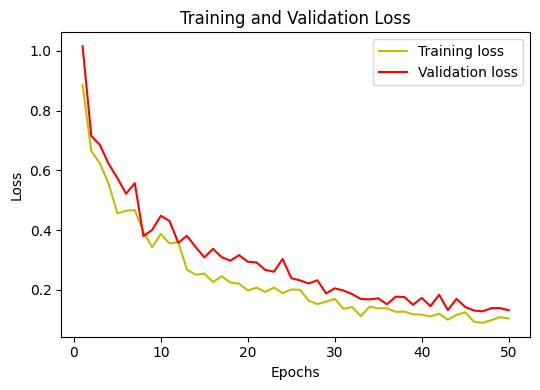

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(5.5, 4))

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(fontsize=10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(False)

plt.tight_layout()
plt.show()

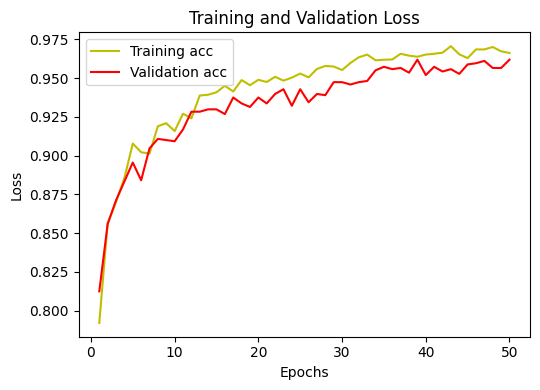

In [23]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(5.5, 4))

plt.plot(epochs, loss, 'y', label='Training acc')
plt.plot(epochs, val_loss, 'r', label='Validation acc')
plt.title('Training and Validation Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(fontsize=10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(False)

plt.tight_layout()
plt.show()